## SPWLA 2021:  GeoLatinas Machine Learning solution
####  Authors: Daniela Navarro Perez, Diana Acero Allard, Ana Gabriela Reyna Flores


### Load libraries


In [1]:
import os
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from tensorflow import keras
from scipy import interpolate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pickle import dump, load

### Prepare dataset

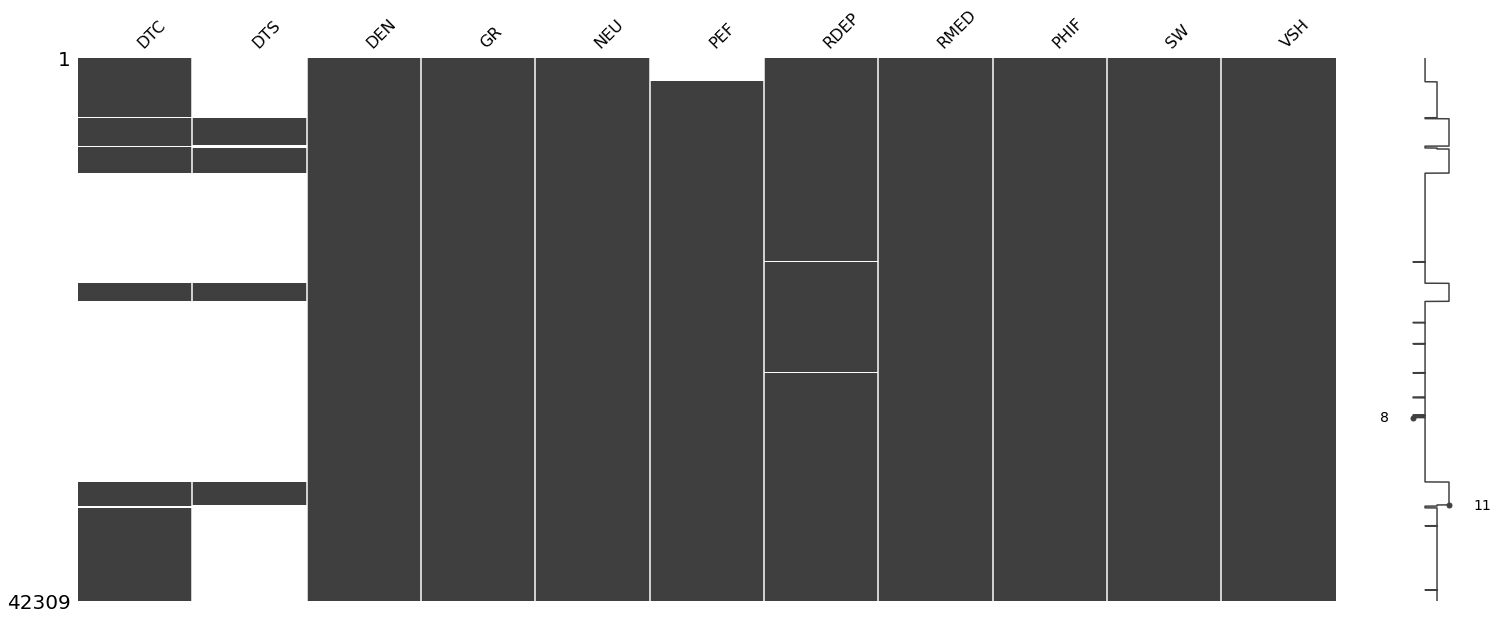

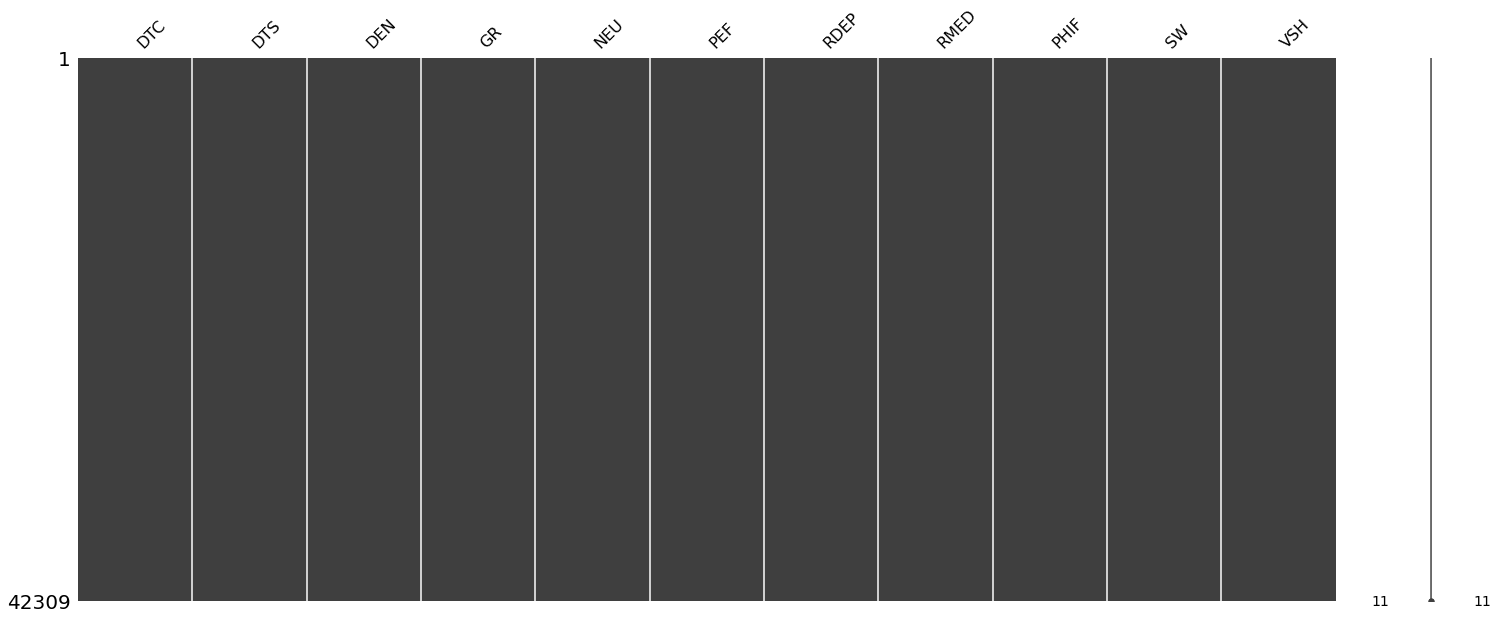

In [2]:
#Load train dataset 
train_path = r"./data/train.csv"
train_data = pd.read_csv(train_path)

#load test dataset
test_path = r"./data/train.csv"
test_data = pd.read_csv(test_path)

logs_discarded = ["BS", "CALI", "DENC", "ROP", "WELLNUM", "DEPTH"]
targets = ['PHIF', 'VSH', 'SW']
features = ["DTC","DTS","DEN","GR","NEU", "PEF","RDEP","RMED"]

#drop irrelevant columns
train_data = train_data.drop(columns=logs_discarded)
test_data =  test_data.drop(columns=logs_discarded)

#convert -9999 values to NaN
train_data = train_data.mask(train_data == -9999.0, np.nan)
test_data = train_data.mask(test_data == -9999.0, np.nan)

#drop row if nan in the target columns for train dataset
train_data = train_data.dropna(subset=targets)

#convert resistivity to log
train_data["RDEP"] = np.log10(train_data['RDEP'])
train_data["RMED"] = np.log10(train_data['RMED'])
test_data["RDEP"] = np.log10(test_data['RDEP'])
test_data["RMED"] = np.log10(test_data['RMED'])

#plot the current state of the dataset
msno.matrix(train_data)

#interpolate missing values 
test_data=test_data.interpolate()
train_data = train_data.interpolate()
pef_mean = np.mean(train_data["PEF"])
train_data['PEF'] = train_data['PEF'].fillna(pef_mean)
dts_mean = np.mean(train_data["DTS"])
train_data['DTS'] = train_data['DTS'].fillna(pef_mean)

#plot dataset after filling missing values
msno.matrix(train_data)

#separate features (x) and targets (y) on training data
x_train = train_data.loc[:, features]
y_train = train_data.loc[:, targets]
x_test = test_data.loc[:, features]


#Normalize data
sc = StandardScaler()
x_train = pd.DataFrame(sc.fit_transform(x_train))
x_test = pd.DataFrame(sc.transform(x_test)) #test data is normalized with the scaler that was fitted on train data
#save scaler for future normalization
dump(sc, open('./scaler/std_scaler.pkl', "wb"))


### Model architecture

In [3]:
def build_model(x_train, y_train):
  model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[len(x_train.keys())]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(len(y_train.keys()))
  ])
  optimizer = keras.optimizers.RMSprop(0.001)
  model.compile(loss="mse",
                optimizer=optimizer,
                metrics=[keras.metrics.RootMeanSquaredError()])
  return model

### Model explanations SHAP (select features)

2022-02-11 15:17:00.479540: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-11 15:17:00.526194: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
22/22 - 1s - loss: 0.0701 - root_mean_squared_error: 0.2647 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1427
Epoch 2/100
22/22 - 0s - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1098
Epoch 3/100
22/22 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1093
Epoch 4/100
22/22 - 0s - loss: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0807
Epoch 5/100
22/22 - 0s - loss: 0.0046 - root_mean_squared_error: 0.0678 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1055
Epoch 6/100
22/22 - 0s - loss: 0.0047 - root_mean_squared_error: 0.0686 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734
Epoch 7/100
22/22 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0794
Epoch 8/100
22/22 - 0s - loss: 0.0038 - root_mean_squared_error: 0.0615 - val_loss: 0.0040 - val_

22/22 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 65/100
22/22 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0565
Epoch 66/100
22/22 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 67/100
22/22 - 0s - loss: 9.4600e-04 - root_mean_squared_error: 0.0308 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0531
Epoch 68/100
22/22 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0533
Epoch 69/100
22/22 - 0s - loss: 9.3820e-04 - root_mean_squared_error: 0.0306 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595
Epoch 70/100
22/22 - 0s - loss: 9.7472e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0748
Epoch 71/100
22/22 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 0.0035

Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/150 [00:00<?, ?it/s]

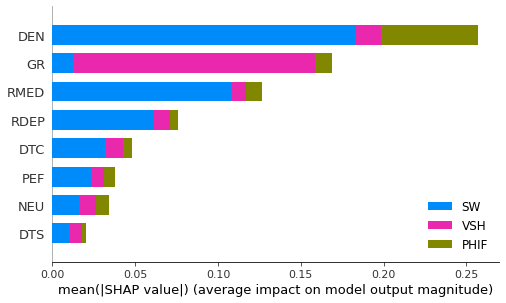

In [4]:
#select subsample from training dataset for SHAP
x_shap = x_train.sample(n=1000,replace=False)
y_shap = y_train.iloc[x_shap.index]

x_shap_train, x_shap_test, y_shap_train, y_shap_test = train_test_split(x_shap, y_shap, test_size=0.15, random_state=42)
#create a model instance
model = build_model(x_shap, y_shap)

#fit data to model
history = model.fit(
  x_shap_train, y_shap_train,
  epochs=100, validation_split = 0.2, verbose=2) 

#explainer instance
explainer = shap.KernelExplainer(model.predict,x_shap_test) #SHAP explainer
shap_values = explainer.shap_values(x_shap_test,nsamples=200)
shap.summary_plot(shap_values,x_shap_test,feature_names=features, class_names = targets)

According to the plot above, DTS is the well-log that contributes the least for the targets prediction. This was an expected result, therefore, we will be not using this log. Also, it was the log that had more missing values. 

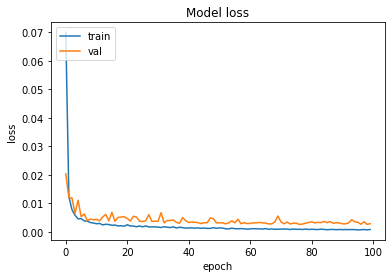

In [5]:
#plot training history
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(history)

### Evaluate model on subsample

5/5 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0505


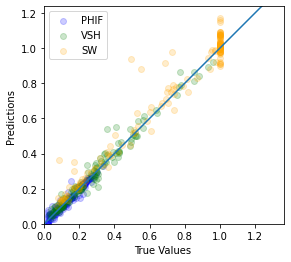

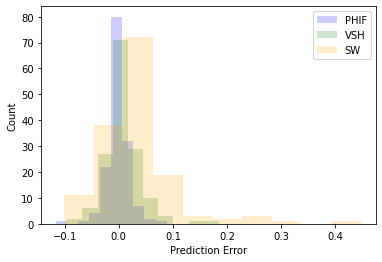

In [6]:
#Evaluate
loss, mse = model.evaluate(x_shap_test, y_shap_test, verbose=2)
test_predictions = model.predict(x_shap_test)

#Plot results
plt.scatter(y_shap_test["PHIF"], test_predictions[:,0], color = "blue", label = targets[0], alpha=0.2)
plt.scatter(y_shap_test["VSH"], test_predictions[:,1], color = "green", label = targets[1], alpha=0.2)
plt.scatter(y_shap_test["SW"], test_predictions[:,2], color = "orange", label = targets[2], alpha=0.2)

plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.legend()
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

error = test_predictions - np.asarray(y_shap_test)

plt.hist(error[:,0], color = "blue", label = targets[0], alpha=0.2)
plt.hist(error[:,1],  color="green", label = targets[1], alpha=0.2)
plt.hist(error[:,2] , color="orange", label = targets[2], alpha=0.2)

plt.legend()
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

### Final model training

          0         2         3         4             5         6         7
0  0.972221  1.037391  1.972771  1.440323  9.003677e-15 -0.292267 -0.372238
1  1.655240  0.396788  3.263439  1.695151  9.003677e-15 -0.331907 -0.377259
2  2.516426 -0.481006  4.577756  3.979781  9.003677e-15 -0.342567 -0.397303
3  3.530407 -1.091104  5.759491  5.960716  9.003677e-15 -0.350494 -0.388705
4  3.989466 -1.140908  8.714187  5.611481  9.003677e-15 -0.369765 -0.390092
Epoch 1/200
1190/1190 - 1s - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0628
Epoch 2/200
1190/1190 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0398 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0325
Epoch 3/200
1190/1190 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 9.0784e-04 - val_root_mean_squared_error: 0.0301
Epoch 4/200
1190/1190 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 7.4098e-04 - val_root_mean_squared_error: 0.0272
Epoc

Epoch 56/200
1190/1190 - 0s - loss: 5.0052e-04 - root_mean_squared_error: 0.0224 - val_loss: 3.2370e-04 - val_root_mean_squared_error: 0.0180
Epoch 57/200
1190/1190 - 0s - loss: 5.0278e-04 - root_mean_squared_error: 0.0224 - val_loss: 2.9288e-04 - val_root_mean_squared_error: 0.0171
Epoch 58/200
1190/1190 - 0s - loss: 4.9759e-04 - root_mean_squared_error: 0.0223 - val_loss: 2.3531e-04 - val_root_mean_squared_error: 0.0153
Epoch 59/200
1190/1190 - 0s - loss: 4.9039e-04 - root_mean_squared_error: 0.0221 - val_loss: 3.2376e-04 - val_root_mean_squared_error: 0.0180
Epoch 60/200
1190/1190 - 0s - loss: 4.9599e-04 - root_mean_squared_error: 0.0223 - val_loss: 3.6348e-04 - val_root_mean_squared_error: 0.0191
Epoch 61/200
1190/1190 - 0s - loss: 4.9209e-04 - root_mean_squared_error: 0.0222 - val_loss: 2.9265e-04 - val_root_mean_squared_error: 0.0171
Epoch 62/200
1190/1190 - 0s - loss: 4.8857e-04 - root_mean_squared_error: 0.0221 - val_loss: 2.8007e-04 - val_root_mean_squared_error: 0.0167
Epoch 

Epoch 114/200
1190/1190 - 0s - loss: 4.4438e-04 - root_mean_squared_error: 0.0211 - val_loss: 5.4472e-04 - val_root_mean_squared_error: 0.0233
Epoch 115/200
1190/1190 - 0s - loss: 4.3713e-04 - root_mean_squared_error: 0.0209 - val_loss: 2.7968e-04 - val_root_mean_squared_error: 0.0167
Epoch 116/200
1190/1190 - 0s - loss: 4.4445e-04 - root_mean_squared_error: 0.0211 - val_loss: 3.8895e-04 - val_root_mean_squared_error: 0.0197
Epoch 117/200
1190/1190 - 1s - loss: 4.3821e-04 - root_mean_squared_error: 0.0209 - val_loss: 2.4954e-04 - val_root_mean_squared_error: 0.0158
Epoch 118/200
1190/1190 - 0s - loss: 4.4454e-04 - root_mean_squared_error: 0.0211 - val_loss: 3.0765e-04 - val_root_mean_squared_error: 0.0175
Epoch 119/200
1190/1190 - 0s - loss: 4.3735e-04 - root_mean_squared_error: 0.0209 - val_loss: 2.6547e-04 - val_root_mean_squared_error: 0.0163
Epoch 120/200
1190/1190 - 0s - loss: 4.4556e-04 - root_mean_squared_error: 0.0211 - val_loss: 3.9663e-04 - val_root_mean_squared_error: 0.0199

Epoch 172/200
1190/1190 - 0s - loss: 4.1743e-04 - root_mean_squared_error: 0.0204 - val_loss: 4.2598e-04 - val_root_mean_squared_error: 0.0206
Epoch 173/200
1190/1190 - 0s - loss: 4.2028e-04 - root_mean_squared_error: 0.0205 - val_loss: 3.2708e-04 - val_root_mean_squared_error: 0.0181
Epoch 174/200
1190/1190 - 0s - loss: 4.2561e-04 - root_mean_squared_error: 0.0206 - val_loss: 3.2017e-04 - val_root_mean_squared_error: 0.0179
Epoch 175/200
1190/1190 - 0s - loss: 4.2477e-04 - root_mean_squared_error: 0.0206 - val_loss: 5.2478e-04 - val_root_mean_squared_error: 0.0229
Epoch 176/200
1190/1190 - 0s - loss: 4.2623e-04 - root_mean_squared_error: 0.0206 - val_loss: 3.1162e-04 - val_root_mean_squared_error: 0.0177
Epoch 177/200
1190/1190 - 0s - loss: 4.2307e-04 - root_mean_squared_error: 0.0206 - val_loss: 2.9329e-04 - val_root_mean_squared_error: 0.0171
Epoch 178/200
1190/1190 - 0s - loss: 4.3269e-04 - root_mean_squared_error: 0.0208 - val_loss: 4.6352e-04 - val_root_mean_squared_error: 0.0215

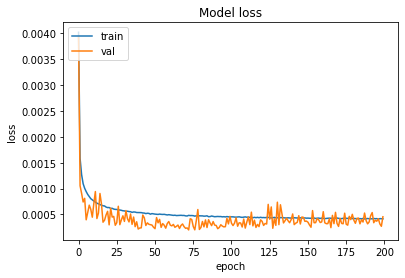

In [7]:
#drop DTS column
x_train.drop([features.index("DTS")], axis = 1, inplace= True)
x_test.drop([features.index("DTS")], axis = 1, inplace = True)
print(x_train.head())

#create a model instance and set checkpoints
checkpoint_path = r"./checkpoint/model_weights.h5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor = "val_loss")
model = build_model(x_train, y_train)

history = model.fit(
  x_train, y_train,
  epochs=200, validation_split = 0.10, verbose=2, callbacks = checkpoint)#just 10% for validation to use most of the data on training

plot_history(history)

### Inference

In [14]:
#Make predictions on test dataset
pred_data = model.predict(x_test)

#convert predictions to dataframe 
pred_data = pd.DataFrame(data=pred_data, index=None, columns=targets)

#trim predictions according to the expected range of targets
print(pred_data.describe())
pred_data.loc[pred_data["SW"] < 0, "SW"] = 0
pred_data.loc[pred_data["SW"] > 1, "SW"] = 1
pred_data.loc[pred_data["PHIF"] < 0, "PHIF"] = 0
pred_data.loc[pred_data["PHIF"] > 1, "PHIF"] = 1
pred_data.loc[pred_data["VSH"] < 0, "VSH"] = 0
print(pred_data.describe())

#save predictions on csv file
pred_data.to_csv("./predictions/predictions_file.csv", index=False)


                PHIF            VSH             SW
count  265133.000000  265133.000000  265133.000000
mean        0.106004       0.398754       0.917398
std         0.064568       0.341038       0.206962
min        -0.398635      -0.178450      -1.673615
25%         0.058338       0.116793       0.898602
50%         0.090571       0.361645       0.997691
75%         0.145345       0.622694       1.020722
max         0.374554       8.719443       2.530108
                PHIF            VSH             SW
count  265133.000000  265133.000000  265133.000000
mean        0.106053       0.400044       0.901512
std         0.064452       0.339417       0.196654
min         0.000000       0.000000       0.000000
25%         0.058338       0.116793       0.898602
50%         0.090571       0.361645       0.997691
75%         0.145345       0.622694       1.000000
max         0.374554       8.719443       1.000000
